<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations. 

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height. 

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. 

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

Solving on periodic domain, so wave will propagate back through the left boundary to the right. 

In [2]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1) 
H.change_scales(1) 
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-12-05 16:49:24,880 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+01/s
2024-12-05 16:49:24,883 __main__ 0/1 INFO :: Starting main loop
2024-12-05 16:49:24,967 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-05 16:49:24,968 solvers 0/1 INFO :: Final iteration: 100
2024-12-05 16:49:24,968 solvers 0/1 INFO :: Final sim time: 6000.0
2024-12-05 16:49:24,968 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3644 sec
2024-12-05 16:49:24,969 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03701 sec
2024-12-05 16:49:24,969 solvers 0/1 INFO :: Run time (iter 10-end): 0.04699 sec
2024-12-05 16:49:24,969 solvers 0/1 INFO :: CPU time (iter 10-end): 1.305e-05 cpu-hr
2024-12-05 16:49:24,969 solvers 0/1 INFO :: Speed: 3.915e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

2024-12-05 16:49:25,010 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-05 16:49:25,011 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/r5/0mjh35v91310vd_3mfx85blw0000gn/T/tmpw2bmbbam/temp.m4v


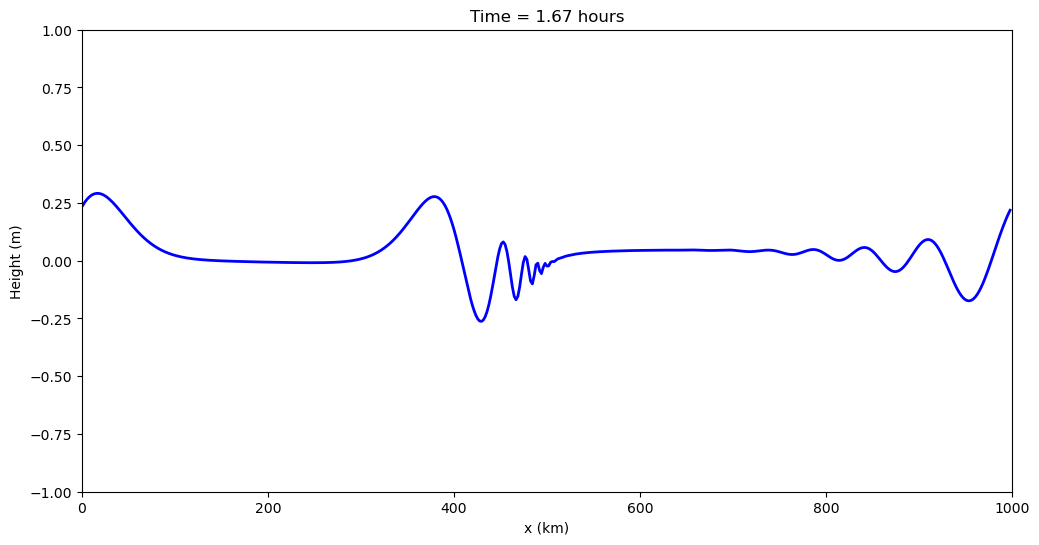

In [3]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))            
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)    

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value. 

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

**Wavespeed = $c = \sqrt{gH}$, assuming the spatial scaling k of the wave in form $u = u_0cos(kx-wt)$ is large?????**

Text(0.5, 1.0, 'Expected Wavespeed')

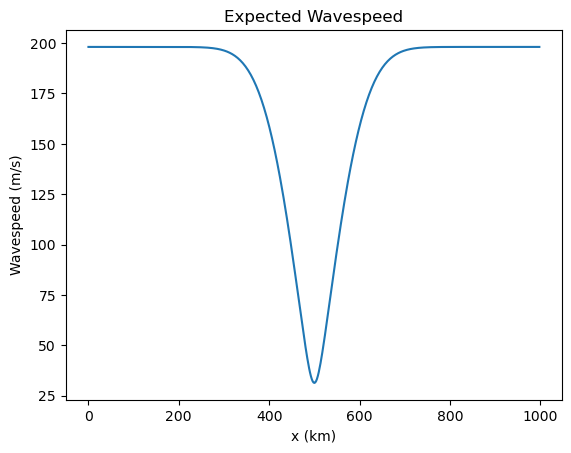

In [4]:
# CREATE FIGURES HERE

#Expected wavespeed: 
c = np.sqrt(g*H['g'])

plt.plot(x/kilometer, c)
plt.xlabel('x (km)')
plt.ylabel('Wavespeed (m/s)')
plt.title('Expected Wavespeed')


In [5]:
print(H['g'].shape)

(512,)


(0.0, 1000.0)

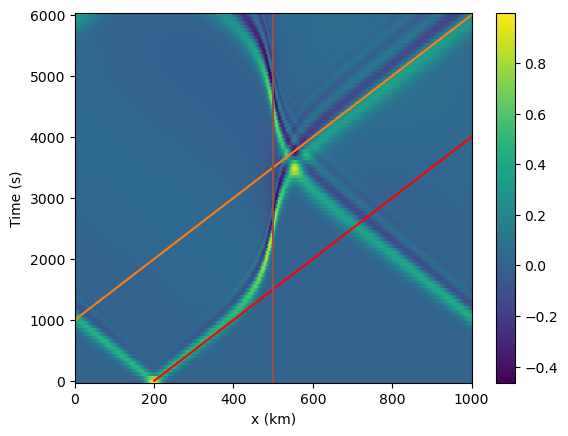

In [6]:
#Model output wavespeed
plt.pcolor(x/kilometer, t_save, h_save, shading='auto')
plt.colorbar()
plt.xlabel('x (km)')
plt.ylabel('Time (s)')
#plt.plot(x,c)
plt.plot(x/kilometer + 200, x/(kilometer)/0.2, 'r')
plt.plot(x/kilometer, x/(kilometer)/0.2 + 1000, 'C1')
plt.axvline(x=500, color='C5',label='seamount')
plt.xlim(0,1000)
#plt.plot(x/kilometer, x/(kilometer*(c/1000)) - 1000, 'r')




In [7]:
h_save.shape
#timestep = 60 * second # Specify the timestep
#stop_sim_time = 100 * minute
len(t_save)

peak_x = []
for i in range(0, len(t_save)):
    peak_x.append(x[np.argmax(h_save[i])])

print(peak_x)
    

[np.float64(199218.75), np.float64(199218.75), np.float64(177734.375), np.float64(166015.625), np.float64(244140.62499999997), np.float64(255859.375), np.float64(267578.125), np.float64(277343.75), np.float64(289062.5), np.float64(300781.25), np.float64(312500.0), np.float64(324218.75000000006), np.float64(333984.375), np.float64(345703.12500000006), np.float64(355468.75), np.float64(367187.5), np.float64(376953.125), np.float64(386718.75000000006), np.float64(396484.375), np.float64(406250.00000000006), np.float64(416015.625), np.float64(423828.125), np.float64(431640.625), np.float64(437500.0), np.float64(445312.5), np.float64(451171.875), np.float64(455078.125), np.float64(460937.5), np.float64(464843.75), np.float64(468749.99999999994), np.float64(472656.25), np.float64(476562.5), np.float64(480468.75), np.float64(482421.875), np.float64(484375.0), np.float64(488281.24999999994), np.float64(490234.37500000006), np.float64(492187.5), np.float64(494140.625), np.float64(496093.75), np

In [8]:
#Could try to capture x position of peak at each timestep
#Something like for each t value in h find the max value and then find the x value at that index
#Could also just limit it to 200 to 500 km to avoid duplicate peak confusion 
timesteps = np.arange(0, stop_sim_time, timestep)
wavepeaks = []
for t in timesteps: 
    x_grid = xbasis.local_grid(xcoord)
    peak_index = np.argmax(u['g'])
    peak_x = x_grid[peak_index]


NameError: name 'xbasis' is not defined

When seamount effects are felt, h increases and speed decreases. 

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [9]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-12-05 16:50:47,837 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-05 16:50:47,853 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+02/s
2024-12-05 16:50:47,872 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2024-12-05 16:50:47,890 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+02/s
2024-12-05 16:50:47,909 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+02/s
2024-12-05 16:50:47,925 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+02/s
2024-12-05 16:50:47,944 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+02/s
2024-12-05 16:50:47,960 subsystems 0/1 INFO :: Building subproblem matric

### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-12-05 16:50:49,742 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-05 16:50:49,743 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/r5/0mjh35v91310vd_3mfx85blw0000gn/T/tmp4im2l2nd/temp.m4v


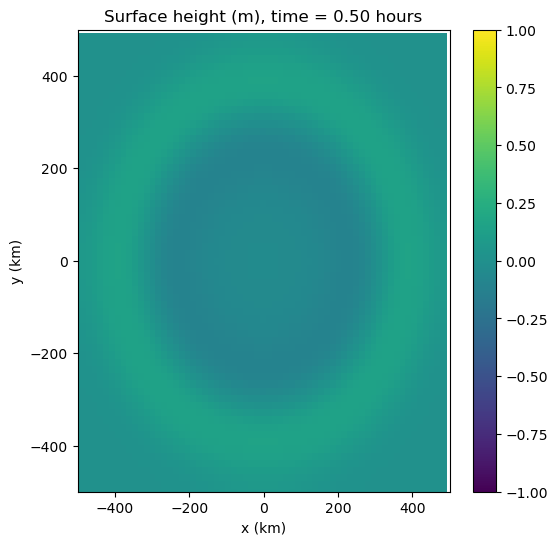

In [10]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))   
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))            
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)
plt.colorbar()

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation. 

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

ADD PREDICTION OF WAVE AMPLITUDE HERE (a few sentences and/or equations)

Considering the properties of a wave, the amplitude is proportional to the square root of intensity. Intensity itself is proportional to energy per area. Originally, there is no kinetic energy and potential energy is focused at the initial height perturbation at the origin. As time proceeds, this wave dissapates outwards, converting potential energy to kinetic and therefore decreasing in height, but also being spread over a greater area. 
Since energy must be conserved, the intesity times area expression must also be constant:

$Intensity \sim Amp^2$ 

$Intensity = \frac{Energy}{Area}$ 

$\implies Energy \sim Amp^2 \times Area$

Area is that of the annulus that spreads out from the origin, width $\delta r$. Hence Area $=2 \pi r \delta r$

Conservation of energy $\implies \int \int PE + KE \, dS = constant $

ie $Energy = constant$ $\implies Amp^2 \times 2 \pi r \delta r = constant$

since this is a scaling estimation, we will discard constants and take the result: $$Amp \sim \frac{1}{\sqrt r}$$

Text(0, 0.5, 'Amplitude (m)')

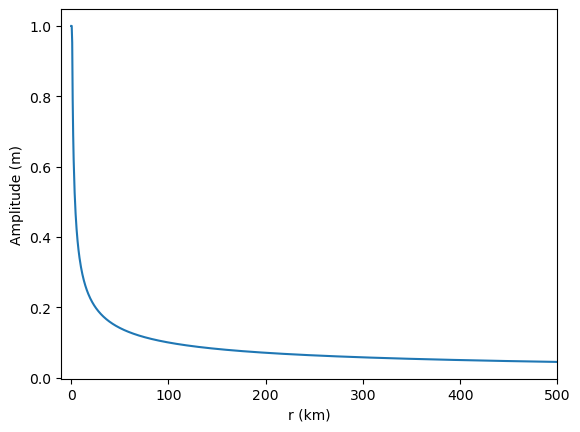

In [11]:
# ADD CODE TO MAKE PLOTS HERE

#Expected amplitude: 
# xs = np.linspace(0, Lx/2, int(Nx/2))
# ys = np.linspace(0, Ly/2, int(Ny/2))
# r = np.sqrt(xs**2 + ys**2)
#plt.axvline(x=0, color ='r')

r = np.linspace(0.1,500,1000)
amp = 1/np.sqrt(r)
amp[0]= 1
amp[1]= 1
plt.plot(r, amp)
plt.xlim(-10,500)
plt.xlabel('r (km)')
plt.ylabel('Amplitude (m)')


[np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32), np.int64(32)]
(31, 32)


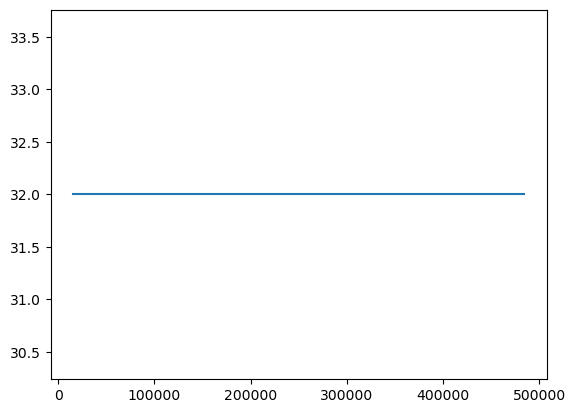

In [12]:

#plt.plot(x[32:], h_save[0,32,:])
peak = []
peak_x = []
for i in range(0, len(t_save)):
    peak.append(np.argmax(h_save[:,32:,:]))
    peak_x.append(x[np.argmax(h_save[i,32:,32])])
print(peak)
print(h_save[:,32:,32].shape)
#print(h_save.shape)
plt.plot(x[33:], peak)

In [13]:
print(int(len(Y+1)/2))

32


[]

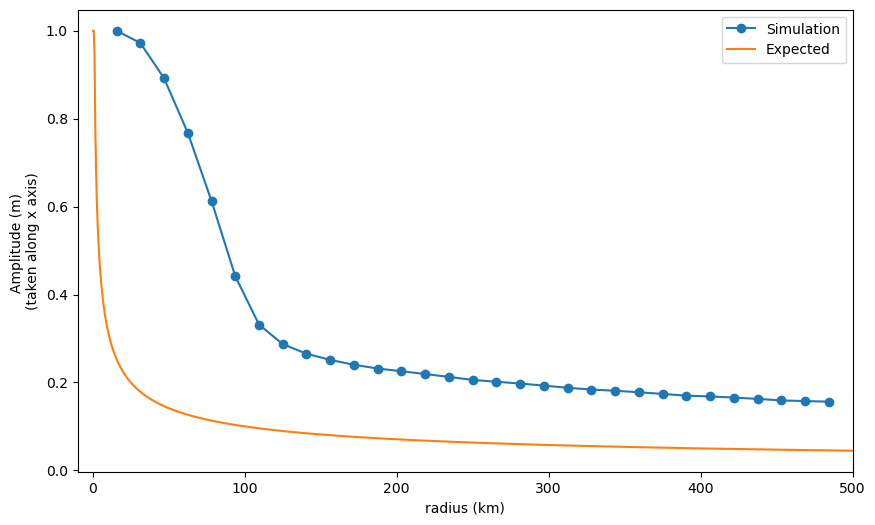

In [14]:
h_xaxis = h_save[:,32,:] #Height along x-axis
max_amplitude = [np.max(h_s) for h_s in h_xaxis]

plt.figure(figsize = (10,6))
plt.plot(x[33:]/kilometer, max_amplitude, marker = 'o', label ='Simulation')
plt.xlabel('radius (km)')
plt.ylabel('Amplitude (m) \n(taken along x axis)')

r = np.linspace(0.1,500,1000)
amp = 1/np.sqrt(r)
amp[0]= 1
amp[1]= 1
plt.plot(r, amp, label = 'Expected')
plt.xlim(-10,500)
plt.legend()

plt.plot()

In [15]:
xs = x[33:]/kilometer
max_amp = np.array(max_amplitude)
xs = xs.flatten()
max_amp = max_amp.flatten()

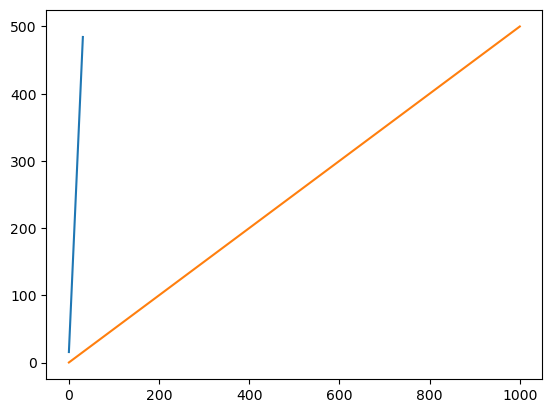

In [16]:
ind1= np.linspace(0, len(xs), len(xs))
plt.plot(ind1,xs)
ind2= np.linspace(0, len(r), len(r))
plt.plot(ind2,r)


[ 3.27796232  0.62005714 -1.17383876]
Optimized parameters: [ 3.27796232  0.62005714 -1.17383876]


/var/folders/r5/0mjh35v91310vd_3mfx85blw0000gn/T/ipykernel_84424/3058701057.py:3: RuntimeWarning: invalid value encountered in sqrt
  return a1/(np.sqrt(a2*x + a3))


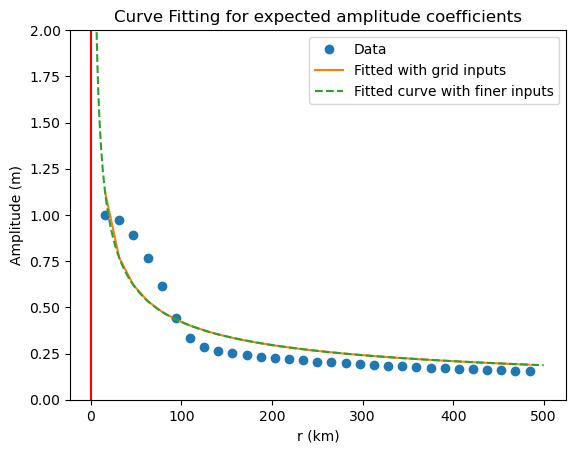

In [17]:
from scipy.optimize import curve_fit
def curve_opt(x, a1, a2, a3):
    return a1/(np.sqrt(a2*x + a3))

init = [1, 1, 1]
popt, pcov = curve_fit(curve_opt, xs, max_amp, p0 = init)

print(popt)

opt_a = popt
print("Optimized parameters:", popt)

fitted_curve1 = curve_opt(xs, opt_a[0], opt_a[1],opt_a[2])
fitted_curve2 = curve_opt(r, opt_a[0],opt_a[1],opt_a[2])

# Plot the data and the fitted curve
plt.plot(xs, max_amp, 'o', label='Data')
plt.plot(xs, fitted_curve1, '-', label='Fitted with grid inputs')
plt.plot(r, fitted_curve2, '--', label='Fitted curve with finer inputs')
plt.xlabel('r (km)')
plt.ylabel('Amplitude (m)')
plt.title('Curve Fitting for expected amplitude coefficients')
plt.axvline(x=0, color = 'r')
plt.ylim(0,2)
plt.legend()
plt.show()



2024-12-05 16:50:58,213 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+02/s
2024-12-05 16:50:58,227 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+02/s
2024-12-05 16:50:58,246 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+02/s
2024-12-05 16:50:58,263 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+02/s
2024-12-05 16:50:58,281 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+02/s
2024-12-05 16:50:58,299 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+02/s
2024-12-05 16:50:58,316 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+02/s
2024-12-05 16:50:58,333 subsystems 0/1 INFO :: Building subproblem matric

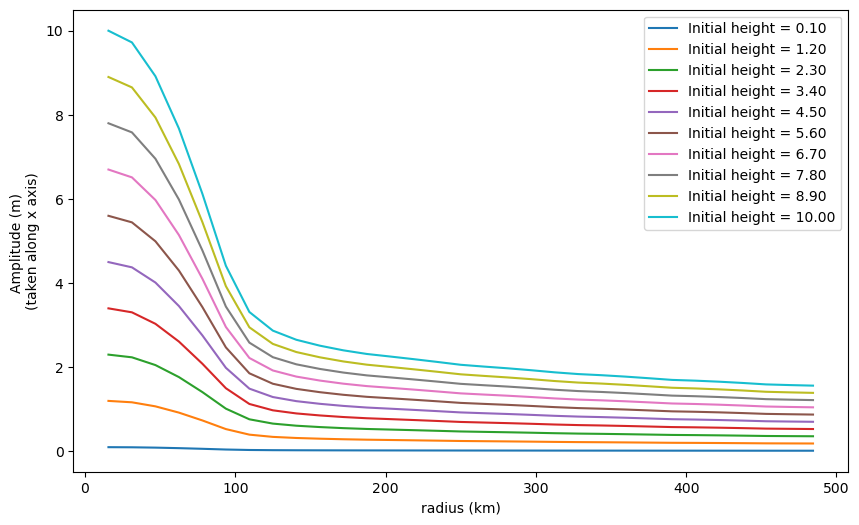

In [18]:
#Varying initial h 
heights = np.linspace(0.1, 10, 10)

fig, ax = plt.subplots(figsize = (10,6))


for i, j in enumerate(heights):
    logger = logging.getLogger(__name__)

    # # Specify the simulation parameters
    # Lx = 1000 * kilometer # The domain size in x
    # Ly = 1000 * kilometer # The domain size in y
    # Nx = 64 # The number of gridpoints in x
    # Ny = 64 # The number of gridpoints in y
    # g = 9.81 * meter / second**2 # Gravitational acceleration
    # H = 4 * kilometer # Reference ocean depth
    # width = 100 * kilometer # Set the width of the initial Gaussian

    # timestep = 60 * second # Specify the timestep
    # stop_sim_time = 30 * minute # Specify the stopping time

    # timestepper = dedalus.RK222
    # max_timestep = 0.125

    # # Bases
    # coords = dedalus.CartesianCoordinates('x', 'y')
    # dist = dedalus.Distributor(coords, dtype=np.float64)
    # xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
    # ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

    # x, y = dist.local_grids(xbasis, ybasis)

    # # Fields
    # u = dist.Field(name='u', bases=(xbasis, ybasis))
    # v = dist.Field(name='v', bases=(xbasis, ybasis))
    # h = dist.Field(name='h', bases=(xbasis, ybasis))

    # Initial conditions
    h.change_scales(1) # Set values on regular grid
    u.change_scales(1)
    v.change_scales(1)
    h['g'] = j * np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
    u['g'] = 0
    v['g'] = 0

    # # Operators
    # dx = lambda a: dedalus.Differentiate(a, coords['x'])
    # dy = lambda a: dedalus.Differentiate(a, coords['y'])

    # Problem
    problem = dedalus.IVP([u, v, h], namespace=locals())
    problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
    problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
    problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Analysis
    snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
    snapshots.add_task(h, name='h')
    snapshots.add_task(u, name='u')
    snapshots.add_task(v, name='v')

    h.change_scales(1)
    h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 1 == 0:
                h.change_scales(1)
                h_save.append(np.copy(h['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
         solver.log_stats()

    h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
    h_xaxis = h_save[:,32,:]
    max_amplitude = [np.max(h_s) for h_s in h_xaxis]

    
    ax.plot(x[33:]/kilometer, max_amplitude, label = f'Initial height = {j:.2f}')
    ax.set_xlabel('radius (km)')
    ax.set_ylabel('Amplitude (m) \n(taken along x axis)')
    ax.legend()

    # r = np.linspace(0.1,500,1000)
    # amp = 1/np.sqrt(r)
    # amp[0]= 1
    # amp[1]= 1
    # plt.plot(r, amp, label = 'Expected')
    # plt.xlim(-10,500)
    # plt.legend()



ADD DISCUSSION HERE (~1 paragraph)

**Simulation vs predicted amplitude:**

<span style ="color:#0D98BA"> The analysis for the expected amplitude showed an inverse relation to square root of radius. Plotting </span> $\frac{1}{\sqrt r}$ <span style ="color:#0D98BA"> shows that the shapes roughly agree, the simulated amplitude has a more sinusoidal shape initially and then decays similarly to the square root for r> 100km, which is due to the gaussian shape of the initial perturbation. A more detailed curve fitting shows that an expression of </span> $$ Amp = \frac{\pi}{\sqrt{0.57r-1.08}}$$ <span style ="color:#0D98BA"> gives a much better agreement until r ~ 20, but still lacks the sinusoidal curvature of the simulated amplitude. </span>

**Varying initial height:**

<span style ="color:#0D98BA"> As initial h increases, the shape of the wave remains the same, but is scaled vertically. The greatest difference occurs in the inital gaussian region (<100 km) where larger values of initial height see greater of amplitude. This makes sense, as a greater initial height would carry more potential energy, and therefore have a greater force acting to propogate this down and outward. The difference between amplitudes at the edge of the simulation is much less than that at the start of the simulation, though still show a constant spacing corresponding to the fixed spacing of initial heights. It is likely that their relative spacings are constant throughout (ie h10-h9 may be smaller at large r, but h10/h9 is constant across r) </span>
<span style ="color:#0D98BA">  </span>

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. 

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [19]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

2024-12-05 16:51:02,210 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 8.6e+01/s
2024-12-05 16:51:02,259 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-05 16:51:02,314 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-05 16:51:02,368 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-05 16:51:02,423 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-05 16:51:02,479 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-05 16:51:02,535 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-05 16:51:02,593 subsystems 0/1 INFO :: Building subproblem matri

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-12-05 16:51:32,191 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-05 16:51:32,192 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/r5/0mjh35v91310vd_3mfx85blw0000gn/T/tmpa6ddqo6d/temp.m4v


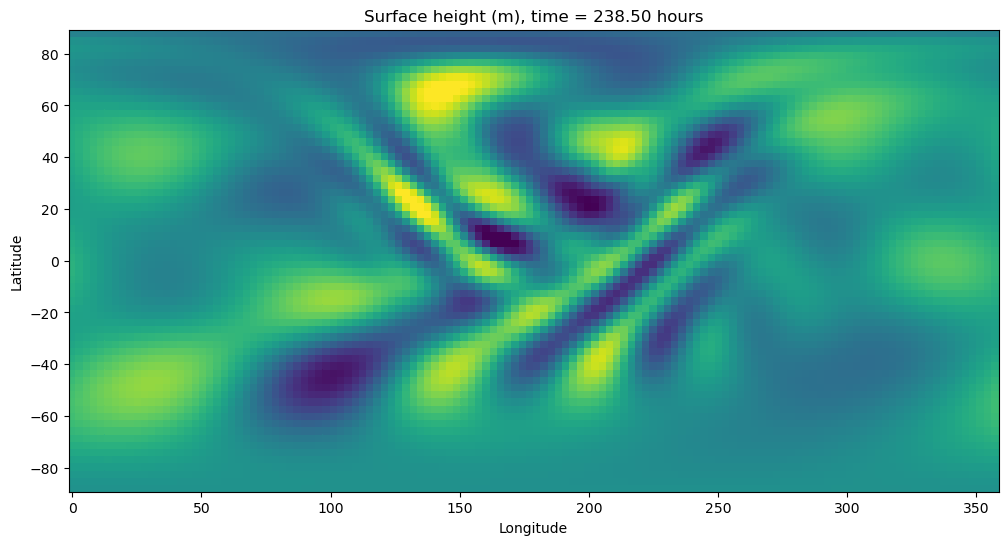

In [20]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)
plt.colorbar()

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

In [21]:
len(t_save)
print(h_save.shape)
tday = np.array(t_save) / (1 * day)

(145, 128, 64)


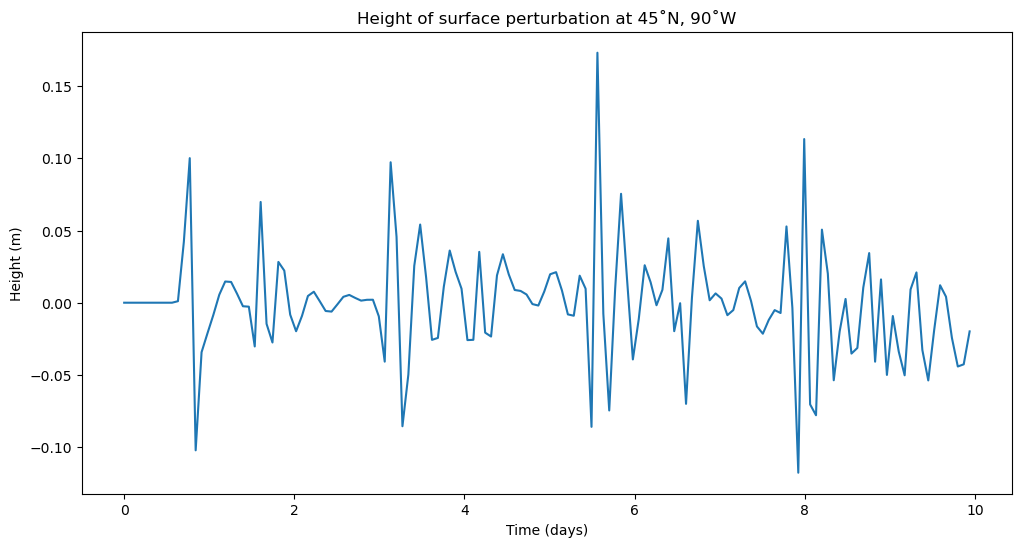

In [22]:
#convert point to lat long 
lat45 = int(Ntheta/4)
long = int(270/360*Nphi)

plt.figure(figsize=(12,6))
plt.plot(tday, h_save[:,long,lat45])
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.title('Height of surface perturbation at 45˚N, 90˚W');

ADD PLOTS AND DISCUSSION HERE

**Physical mechanisms:**

#CHECK DISSIPATION
<span style ="color:#0D98BA"> - Dissipation: In the above model, there is no dissipative term that removes energy from the wave as it progresses, therefore meaning it is able to continue to travel around the world. This is a key underlaying factor for the following </span>

<span style ="color:#0D98BA"> - Rotation: As the wave propogates out from the source, the rotation of the Earth means that the Eastward propogating limb has the rotation acting against it, while the Westward limb is aided by rotation. This means that as the wave completes a full journey to the opposite side of the globe that it started on and converges, it does so out of phase. It is unclear whether there is inbuilt collisional terms, and assuming they are absent this means that this process of separation of the initial wave into wavelets as a result of rotation continues until there are many waves of small wavelength propagating simultaneously. This rotational effect is felt **more / less**  at the poles as a result of the zcross dependency on latitude</span>
#FURTHER CHECK ON EFFECT OF LATITUDE

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

2024-12-05 16:51:45,423 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-05 16:51:45,454 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-12-05 16:51:45,492 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-12-05 16:51:45,530 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-12-05 16:51:45,568 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-12-05 16:51:45,606 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-12-05 16:51:45,645 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-12-05 16:51:45,683 subsystems 0/1 INFO :: Building subproblem matri

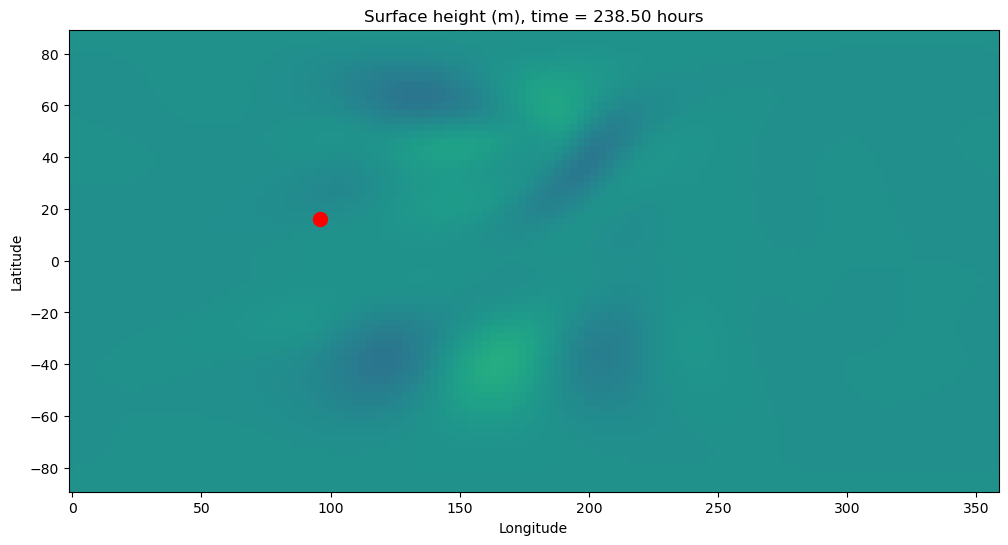

In [23]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

#Operator
f_x = dist.Field(bases=basis)
f_x['g'] = 1/2 * (1 + np.tanh((phi-3/2*np.pi)/(np.pi/10)))+ 1/2 * (1 - np.tanh((phi-1/2*np.pi)/(np.pi/10)))

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - (1/(0.1*day))*f_x*h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    plt.scatter(int(270/360*Nphi),int(Ntheta/4),color='r',s=100)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [24]:
print(h_save.shape)

(145, 128, 64)


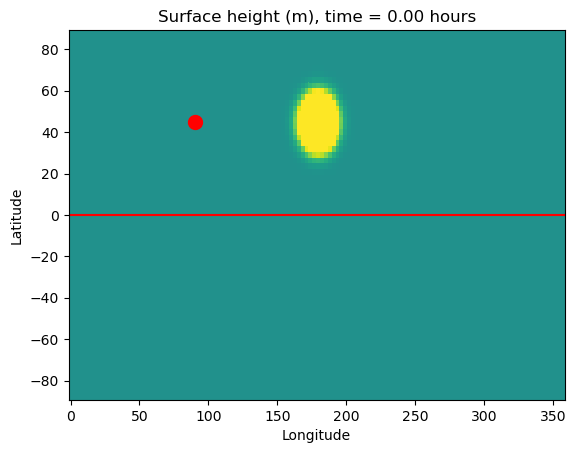

In [25]:
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    plt.scatter(90,45,color='r',s=100)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

# from matplotlib import animation
# # blit=True re-draws only the parts that have changed.
# anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)
drawframe(0)
plt.axhline(y=0, color='r', linestyle='-')

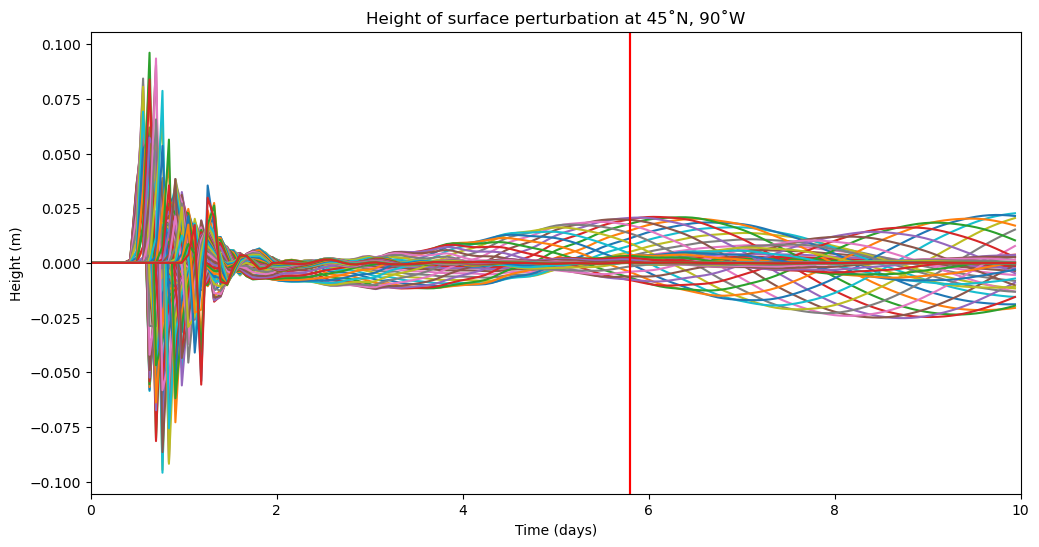

In [26]:
#convert point to lat long 
lat45 = int(Ntheta/4)
long = int(270/360*Nphi)

plt.figure(figsize=(12,6))
# plt.plot(tday, h_save[:,long,lat45],label = '90˚E')
for i in range(0,Nphi,2):
    plt.plot(tday, h_save[:,i,int(Ntheta/4)],label = '180˚')
# plt.plot(tday, h_save[:,int(135/360*Nphi),lat45],label = '135˚E')
# plt.plot(tday, h_save[:,int(135/360*Nphi),lat45],label = '135˚E')
plt.axvline(x=5.8, color='r')
plt.axvline(x=5.8, color='r')
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.xlim(0,10)
# plt.legend()
plt.title('Height of surface perturbation at 45˚N, 90˚W');

In [27]:
len(t_save)

145

Estimate slope = -4857.085714285714
estimate wavespeed = -0.02 km/s = -16.47 m/s


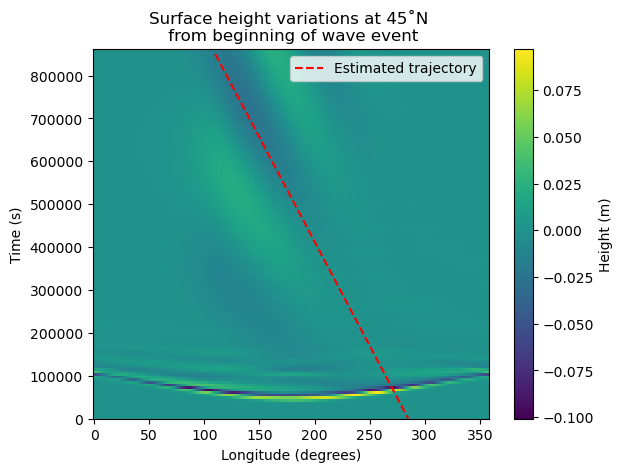

In [54]:
longit = phi.flatten()*180/np.pi
plt.pcolormesh(longit,t_save,h_save[:,:,lat45])
plt.xlabel('Longitude (degrees)')
plt.ylabel('Time (s)')
plt.plot([110,285],[850000,10], 'r--',label='Estimated trajectory')
plt.legend()
plt.title('Surface height variations at 45˚N \n from beginning of wave event')
plt.colorbar(label='Height (m)')

slope = (10-850000)/(285-110)
print(f'Estimate slope = {slope}')
print(f'estimate wavespeed = {1/slope * 80:.2f} km/s = {1/slope * 80*1000:.2f} m/s') #Longitude/ time * distance / longtitude (roughly 80km per degree at 45˚N)

# plt.pcolor(x/kilometer, t_save, h_save, shading='auto')


**Estimate of E/W phase speed of Rossby waves:**
Phase speed = 
Based on the above plot, it takes 
wavelength ~ 40 longitude degrees 


Expression for rossby wave phase speed $= -\beta * K1 (K1*K2)/(K1**2+K2**2)**0.5$
$$w = \frac{-k \beta}{k^2+l^2+\frac{f_0^2}{gH_0}} $$

$$\implies c_p = \frac{-\beta}{k^2+l^2+\frac{f_0^2}{gH_0}} $$

get k and l from width of initial gaussian, wavelength= 14000m, so k = l = , H = 1m, f0 = 2*Omega 
$$\beta = \partial_f/\partial_y = 2\Omega cos(\theta)/a$$
$$ = 1.6 \times 10^{-11} $$

$$\implies c_p = 3.96 \times 10^{-5} m/s \space west $$



In [71]:
wd = 2*np.pi*10/360 *180 / np.pi #Width in degrees 
wkm = 2*np.pi*10/360 * 80 #Width in km at 45˚N 
print(f'Width in m = {1000*wkm:.2f}')
wavenumber = 2*np.pi/(wkm*1000)
print (f'Wavenumber = {wavenumber:.2e} per m')

beta45 = 2*Omega*np.cos(45*np.pi/180)/R
print(f"Beta at 45˚N = {beta45:.2e}")

c_p= -beta45 / (2* wavenumber**2 + (2*Omega)**2/ (g))
print(f'Phase speed = {c_p} m/s')

Width in m = 13962.63
Wavenumber = 4.50e-04 per m
Beta at 45˚N = 1.61e-11
Phase speed = -3.964572715963592e-05 m/s


In [73]:
2*Omega

0.0001454441043328608

Extra perturbation from initial gaussian volume. Wavelength of rossby should then be similar to initial gaussian (gives k and l to calculate phase speed)

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?